In [1]:
import pandas as pd
import contextily as ctx
from mapbox import Directions
import googlemaps
import multiprocessing
from functools import partial
import plotly.express as px
from googlemaps import Client as GoogleMaps
from datetime import datetime
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
from pandana.loaders import osm
import geopandas as gpd
import mapclassify
import pydeck as pdk
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# New York Sate (FIFP=36) block shapfile data
url = "https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/tl_2020_36_tabblock20.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()
gdf = gpd.read_file('tl_2020_36_tabblock20.shp')

# Filter the data to include only NYC counties
nyc_counties = ["005", "047", "061", "081", "085"]
nyc_block_data = gdf[gdf["COUNTYFP20"].isin(nyc_counties)]

# Filter out water features (coastline)
nyc_block_data = nyc_block_data[nyc_block_data["ALAND20"] > 0]

# Desired variables
# nyc_block_data['Tract_GEOID'] = nyc_block_data['STATEFP20'] + nyc_block_data['COUNTYFP20'] + nyc_block_data['TRACTCE20']
nyc_block_data = nyc_block_data[["GEOID20", "geometry"]]
nyc_block_data = nyc_block_data.rename(columns={"GEOID20": "GEOID"})

nyc_block_data.head()

,GEOID,geometry
210,360810656001009,"POLYGON ((-73.73351 40.66322, -73.73186 40.664..."
242,360810155001002,"POLYGON ((-73.91740 40.75822, -73.91549 40.760..."
243,360811187001002,"POLYGON ((-73.81227 40.76113, -73.81105 40.761..."
244,360810991005000,"POLYGON ((-73.80140 40.79429, -73.80034 40.794..."
245,360810240001001,"POLYGON ((-73.80923 40.70370, -73.80879 40.703..."


### EV CO2

In [30]:
filename = 'NYC_EV_CO2.csv'
CO2 = pd.read_csv(filename)
CO2.head()

,Unnamed: 0,primary_mode,trip_distance_meters,origin_bgrp_fips_2020,origin_bgrp_lat_2020,origin_bgrp_lng_2020,destination_bgrp_fips_2020,destination_bgrp_lat_2020,destination_bgrp_lng_2020,emission_factor,co2_emissions_grams
0,817,private_auto,2869.861115,360470129014,40.6826,-73.9779,360470317011,40.6748,-73.9500,175.0,502.225695
1,932,private_auto,1958.449908,360470414022,40.6022,-73.9686,360470582002,40.5973,-73.9600,175.0,342.728734
2,1399,private_auto,11542.946199,360810590001,40.7013,-73.7370,360810716001,40.6469,-73.7869,175.0,2020.015585
3,1410,private_auto,3616.697673,360811467002,40.7609,-73.7733,360811479001,40.7725,-73.7380,175.0,632.922093
4,1819,private_auto,1931.481372,360810997051,40.7875,-73.7860,360810997044,40.7799,-73.7776,175.0,338.009240


In [35]:
block = nyc_block_data
hexes = h3fy(block, resolution=8, clip=True)  # 8: edge length of approximately 0.74 km and spans an area of approximately 3 km²
hexes.head()

,geometry
hex_id,
882a106e0dfffff,"POLYGON ((-74.24006 40.50163, -74.23813 40.506..."
882a106e63fffff,"POLYGON ((-74.23813 40.50608, -74.24006 40.501..."
882a106e67fffff,"POLYGON ((-74.24888 40.50840, -74.25081 40.503..."
882a106e47fffff,"POLYGON ((-74.21910 40.50927, -74.22103 40.504..."
882a106e6bfffff,"POLYGON ((-74.22985 40.51159, -74.23179 40.507..."


In [ ]:
'''

access_token = 'pk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHYxZjN1bWkwNmNrMmtwNzg5MzBhbTBhIn0.bzHjCMX2yvJdC-FkMckvJw'
directions_service = Directions(access_token=access_token)

def fetch_routes(batch):
    """ Fetch routes for a batch of origins and destinations """
    results = []
    for origin, destination in batch:
        response = directions_service.directions([origin, destination], 'mapbox/driving')
        if response.status_code == 200:
            route = response.geojson()['features'][0]['geometry']
            results.append(LineString(route['coordinates']))
        else:
            results.append(None)
    return results

CO2 = CO2[['origin_bgrp_lng_2020', 'origin_bgrp_lat_2020', 'destination_bgrp_lng_2020', 'destination_bgrp_lat_2020', 'co2_emissions_grams']]

# Creating tuples of origin and destination points
points = [
    (Point(row['origin_bgrp_lng_2020'], row['origin_bgrp_lat_2020']),
     Point(row['destination_bgrp_lng_2020'], row['destination_bgrp_lat_2020']))
    for index, row in CO2.iterrows()
]

# Process in batches using multiprocessing
cpu_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpu_cores)
batch_size = len(points) // cpu_cores
batches = [points[i:i + batch_size] for i in range(0, len(points), batch_size)]
routes = pool.map(fetch_routes, batches)
pool.close()
pool.join()

# Flatten the list of routes
routes = [route for batch in routes for route in batch]
CO2['shortest_path'] = routes

# Convert to GeoDataFrame
CO2_geo = gpd.GeoDataFrame(CO2, geometry='shortest_path', crs='EPSG:4326')
CO2_geo['trip_id'] = CO2_geo.index

hexes = hexes.reset_index(drop=True)

# Perform overlay operation
intersections = gpd.overlay(CO2_geo, hexes[['hex_id', 'geometry']], how='intersection', keep_geom_type=False)

# Calculate emissions per intersected hex
intersections['count'] = intersections.groupby('trip_id')['geometry'].transform('count')
intersections['emissions_per_hex'] = intersections['co2_emissions_grams'] / intersections['count']
total_emissions = intersections.groupby('hex_id')['emissions_per_hex'].sum().reset_index()

# Reset index before merging to avoid ambiguity
total_emissions = total_emissions.reset_index(drop=True)

# Merge with hexes and replace NaN values with zero
hexes = hexes.merge(total_emissions, on='hex_id', how='left')
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hexes.plot(column='emissions_per_hex', cmap='viridis', legend=True, ax=ax)
ax.set_title('CO2 Emissions per Hex')
plt.show()

'''

In [31]:
# Initialize the Directions service with your Mapbox access token
access_token = 'pk.eyJ1IjoiemV5dXd1MjAwMSIsImEiOiJjbHYxZjN1bWkwNmNrMmtwNzg5MzBhbTBhIn0.bzHjCMX2yvJdC-FkMckvJw'
directions_service = Directions(access_token=access_token)

def fetch_route(origin, destination):
    """ Fetch the shortest path using Mapbox Directions API """
    response = directions_service.directions([origin, destination], 'mapbox/driving')
    if response.status_code == 200:
        # Extract route as LineString if the response is successful
        routes = response.geojson()['features'][0]['geometry']
        return LineString(routes['coordinates'])
    else:
        return None

CO2 = CO2[['origin_bgrp_lng_2020',	'origin_bgrp_lat_2020', 'destination_bgrp_lng_2020', 'destination_bgrp_lat_2020', 'co2_emissions_grams']]
CO2.shape

(28926, 5)

In [32]:
# sampled_data = CO2.sample(n=1000, random_state=42)  # sampled_data = CO2.sample(frac=0.1)

# Use apply to create a new column 'shortest_path' with the LineString of the route
CO2['shortest_path'] = CO2.apply(lambda row: fetch_route(
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['origin_bgrp_lng_2020'], row['origin_bgrp_lat_2020']]}},
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['destination_bgrp_lng_2020'], row['destination_bgrp_lat_2020']]}
    }), axis=1)

# Convert CO2 to a GeoDataFrame with the new 'shortest_path' geometry
CO2_geo = gpd.GeoDataFrame(CO2, geometry='shortest_path', crs=hexes.crs)
CO2_geo['trip_id'] = CO2_geo.index
CO2_geo.head()

,origin_bgrp_lng_2020,origin_bgrp_lat_2020,destination_bgrp_lng_2020,destination_bgrp_lat_2020,co2_emissions_grams,shortest_path,trip_id
0,-73.9779,40.6826,-73.9500,40.6748,502.225695,"LINESTRING (-73.97789 40.68262, -73.97562 40.6...",0
1,-73.9686,40.6022,-73.9600,40.5973,342.728734,"LINESTRING (-73.96861 40.60224, -73.96636 40.6...",1
2,-73.7370,40.7013,-73.7869,40.6469,2020.015585,"LINESTRING (-73.73701 40.70111, -73.73632 40.7...",2
3,-73.7733,40.7609,-73.7380,40.7725,632.922093,"LINESTRING (-73.77366 40.76087, -73.77387 40.7...",3
4,-73.7860,40.7875,-73.7776,40.7799,338.009240,"LINESTRING (-73.78603 40.78753, -73.78649 40.7...",4


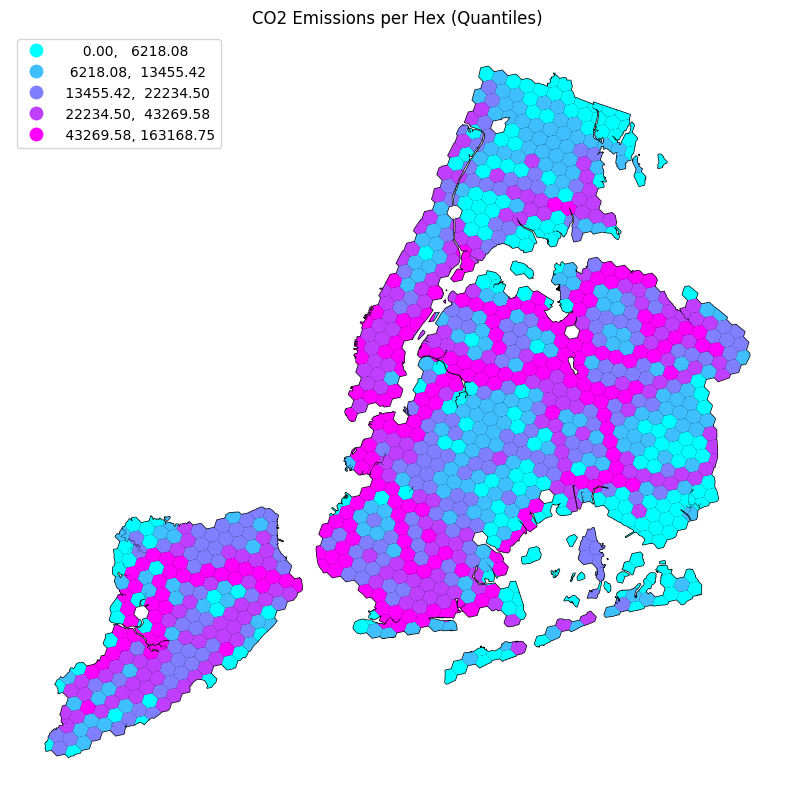

In [66]:
hexes = hexes.reset_index()

# Perform overlay operation
intersections = gpd.overlay(CO2_geo, hexes[['hex_id', 'geometry']], how='intersection', keep_geom_type=False)

# Calculate emissions per intersected hex
intersections['count'] = intersections.groupby('trip_id')['geometry'].transform('count')
intersections['emissions_per_hex'] = intersections['co2_emissions_grams'] / intersections['count']
total_emissions = intersections.groupby('hex_id')['emissions_per_hex'].sum().reset_index()

# Reset index before merging to avoid ambiguity
total_emissions = total_emissions.reset_index(drop=True)

# Merge with hexes and replace NaN values with zero
hexes = hexes.merge(total_emissions, on='hex_id', how='left')
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
base = hexes.plot(color='white', edgecolor='black', ax=ax)
hexes.plot(ax=base, column='emissions_per_hex', cmap='cool', scheme='quantiles', k=5,   # cmap='cool' 'hot' 'viridis' 'plasma'  scheme='quantiles' 'equal_interval'
           legend=True, markersize=hexes['emissions_per_hex']/100, legend_kwds={'loc': 'upper left'}) 
ax.set_title('CO2 Emissions per Hex (Quantiles)')
ax.axis('off')
plt.show()

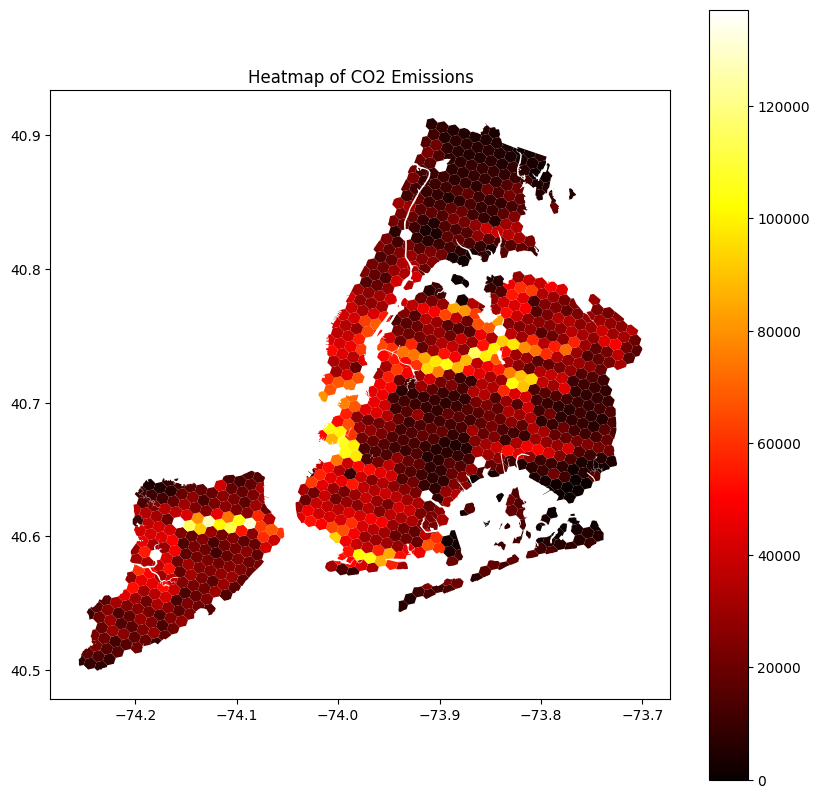

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
density = gaussian_filter(hexes['emissions_per_hex'], sigma=1)
hexes['density'] = density
hexes.plot(column='density', cmap='hot', legend=True, ax=ax)
ax.set_title('Heatmap of CO2 Emissions')
plt.show()

Routing Network Visualization

In [14]:
df = pd.read_csv('NYC_EV_CO2_geo.csv')
df = df.drop(df.columns[[0]], axis=1)
df.head()

,origin_bgrp_lng_2020,origin_bgrp_lat_2020,destination_bgrp_lng_2020,destination_bgrp_lat_2020,co2_emissions_grams,shortest_path,trip_id
0,-73.9779,40.6826,-73.9500,40.6748,502.225695,"LINESTRING (-73.97789 40.68262, -73.97562 40.6...",0
1,-73.9686,40.6022,-73.9600,40.5973,342.728734,"LINESTRING (-73.96861 40.60224, -73.96636 40.6...",1
2,-73.7370,40.7013,-73.7869,40.6469,2020.015585,"LINESTRING (-73.73701 40.70111, -73.73632 40.7...",2
3,-73.7733,40.7609,-73.7380,40.7725,632.922093,"LINESTRING (-73.77366 40.76087, -73.77387 40.7...",3
4,-73.7860,40.7875,-73.7776,40.7799,338.009240,"LINESTRING (-73.78603 40.78753, -73.78649 40.7...",4


In [15]:
# Check if all entries are strings, if not, filter out the non-string entries
df = df[df['shortest_path'].apply(lambda x: isinstance(x, str))]
df['geometry'] = gpd.GeoSeries.from_wkt(df['shortest_path'])
df = gpd.GeoDataFrame(df, geometry='geometry')
df.set_crs(epsg=4326, inplace=True)

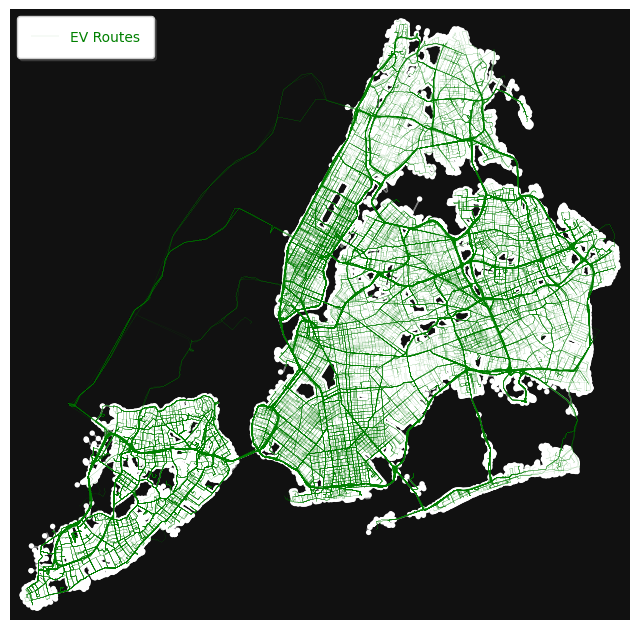

In [24]:
G = ox.graph_from_place('New York City, New York, USA', network_type='drive')
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='gray', edge_linewidth=1.0)

# Highlight the routes by using a light green color and an appropriate line width
ev_route_lines = df.plot(ax=ax, linewidth=0.05, edgecolor='green', label='EV Routes')
legend = ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
for text in legend.get_texts():
    text.set_color('green')
plt.show()